### Setup

In [1]:
# dependencies
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
my_dir = os.path.dirname(os.path.abspath('__file__'))
os.chdir(my_dir)

In [2]:
# add the case shiller price index to the data in order to incorporate national price trends
ames = 'data/ames_housing_data/AmesHousing.csv'
case_shiller = 'data/cs_index_us.csv'

ames_df = pd.read_csv(ames)
cs_df = pd.read_csv(case_shiller)

In [3]:
ames_df = ames_df.merge(cs_df, left_on = 'Yr Sold', right_on = 'Year', how = 'left')
ames_df.drop(columns = ['Year'], inplace = True)

In [4]:
ames_df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Avg CS Index Value
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,215000,144.67
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000,144.67
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000,144.67
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,244000,144.67
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900,144.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500,183.48
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000,183.48
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000,183.48
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2006,WD,Normal,170000,183.48


### Data Cleaning & Feature Engineering (sort of)

In [5]:
numerical_features = ames_df.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    ames_df[feature].fillna(ames_df[feature].median(), inplace=True)

In [6]:
categorical_features = ames_df.select_dtypes(include=[np.object]).columns.tolist()
for feature in categorical_features:
    ames_df[feature].fillna('None', inplace=True)

/var/folders/hl/p3c4xh5x4nv00kvc7sckx1040000gn/T/ipykernel_9683/1298506737.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features = ames_df.select_dtypes(include=[np.object]).columns.tolist()


In [17]:
ames_df['Total SF'] = ames_df['Total Bsmt SF'] + ames_df['1st Flr SF'] + ames_df['2nd Flr SF']

In [ ]:
ames_df.to_csv('data/ames_data_for_model.csv')

In [18]:
# Look for outliers
fig = px.scatter(ames_df, x='Gr Liv Area', y='SalePrice', hover_name=ames_df.index)

# Calculate R^2 value for the trendline
X = ames_df['Gr Liv Area']
y = ames_df['SalePrice']
p = np.polyfit(X, y, 1)  # get linear fit parameters
y_fit = np.polyval(p, X)  # compute y values using the fit
r2 = r2_score(y, y_fit)

# Add annotation for R^2 value on the plot
fig.add_annotation(
    x=np.max(X) * 0.6,
    y=np.min(y_fit),
    text=f"R^2 = {r2:.4f}",
    showarrow=False
)
fig.show()

In [19]:
ames_df=ames_df[ames_df['Gr Liv Area']<4000]

In [20]:
fig = px.scatter(ames_df, x='Gr Liv Area', y='SalePrice', hover_name=ames_df.index)

# Calculate R^2 value for the trendline
X = ames_df['Gr Liv Area']
y = ames_df['SalePrice']
p = np.polyfit(X, y, 1)  # get linear fit parameters
y_fit = np.polyval(p, X)  # compute y values using the fit
r2 = r2_score(y, y_fit)

# Add annotation for R^2 value on the plot
fig.add_annotation(
    x=np.max(X) * 0.6,
    y=np.min(y_fit),
    text=f"R^2 = {r2:.4f}",
    showarrow=False
)

fig.show()

In [21]:
# Now we encode
ames_df = pd.get_dummies(ames_df)

### Feature Scaling

In [22]:
scaler = StandardScaler()
ames_df[numerical_features] = scaler.fit_transform(ames_df[numerical_features])

### Model Training

Seting up train and test set

In [23]:
X = ames_df.drop('SalePrice', axis=1)  # All columns except target variable
y = ames_df['SalePrice']  # Target variable

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression

In [29]:
# Create and fit Linear Regerssion model to training set
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test (or validation set)
y_pred_lr = model.predict(X_test)

# Print R-Squared and MSE
print(f"Training R-Squared: {model.score(X_train, y_train):.4f}")
print(f"Testing R-Squared: {model.score(X_test, y_test):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lr):.4f}")

Training R-Squared: 0.9401
Testing R-Squared: 0.9397
Mean Squared Error: 0.0695


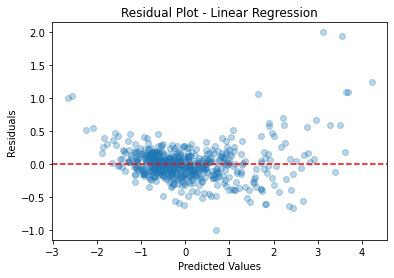

In [34]:
residuals_lr = y_test - y_pred_lr
plt.scatter(y_pred_lr, residuals_lr, alpha = 0.3)
plt.axhline(y = 0, color = "red", linestyle = '--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Linear Regression')
plt.show()


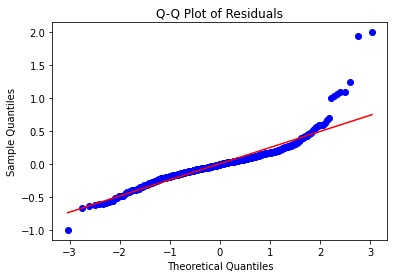

In [37]:
# Q-Q Plot
stats.probplot(residuals_lr, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

XG Boost

In [26]:
from warnings import filterwarnings
filterwarnings('ignore')

# Create a Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'loss': ['ls', 'lad', 'huber']
}

# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model from the grid search 
best_params = grid_search.best_params_

# Train a model using the best parameters
best_model = GradientBoostingRegressor(random_state=42, **best_params)
best_model.fit(X_train, y_train)

print(f"Best Parameters: {best_params}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

print(f"Training R-Squared: {best_model.score(X_train, y_train)}")
print(f"Testing R-Squared: {best_model.score(X_test, y_test)}")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Best Parameters: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Training R-Squared: 0.9753657335347331
Testing R-Squared: 0.9521815989182851
Mean Squared Error: 0.05511327014089743


Results:

* Best Parameters: {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
* Training R-Squared: 0.9753657335347331
* Testing R-Squared: 0.9521815989182851
* Mean Squared Error: 0.05511327014089743

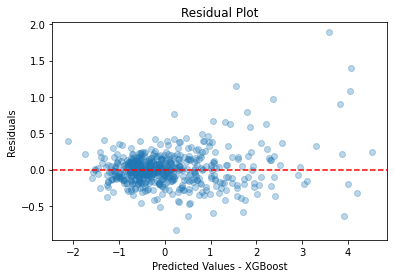

In [39]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha = 0.3)
plt.axhline(y = 0, color = "red", linestyle = '--')
plt.xlabel('Predicted Values - XGBoost')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


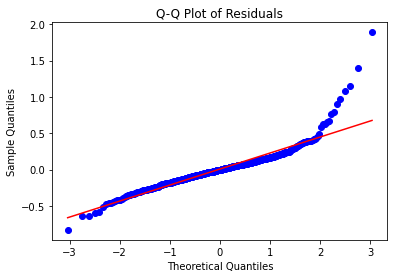

In [40]:
# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

In [27]:
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']